In [1]:
from firedrake import *
from firedrake.petsc import PETSc
import os
from firedrake.__future__ import interpolate
from firedrake.output import VTKFile

printpar = PETSc.Sys.Print        # print once even in parallel

In [2]:
def generate_mesh(xt, yt, xb, yb, lcs):
    
    # generate a geo file and mesh for a surface given by (xt,yt) and a bottom given by (xb, yb)
    # xb should run backwards
    # lcs are a tuple describing different grid cell lengths for the mesh
    
    (lc1, lc2, lc3) = lcs
    
    fd = open('channel.geo', 'w', newline="")
    #fd.write('lc = 25;\n')
    Np = len(xt)
    Lp = max(xt)

    fd.write(f'lc1 = {lc1};\n')
    fd.write(f'lc2 = {lc2};\n')
    fd.write(f'lc3 = {lc3};\n')

    line1 = []
    line2 = []
    line3 = []
    line4 = []
    line5 = []
    
    line6 = []
    line7 = []
    line8 = []
    line9 = []
    line10 = []
    
    
    for k in range(Np):
        if xt[k] <= Lp / 4:
            point = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc1};\n'
            fd.write(point)
            line1.append(str(k + 1))
        elif xt[k] <= 3 * Lp / 8:
            point = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc2};\n'
            fd.write(point)
            line2.append(str(k + 1))
        elif xt[k] < 5 * Lp / 8:
            point = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc3};\n'
            fd.write(point)
            line3.append(str(k + 1))
        elif xt[k] < 3 * Lp / 4:
            point = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc2};\n'
            fd.write(point)
            line4.append(str(k + 1))
        else:
            point = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc1};\n'
            fd.write(point)
            line5.append(str(k + 1))

    Nb = len(xb)
    Lb = max(xb)
    for k in range(Nb):
        if xb[k] > 3 * Lb / 4:
            point = 'Point(' + str(k + Np + 1) + ') = {' + str(xb[k]) + ',' + str(yb[k]) + ',0,lc1};\n'
            fd.write(point)
            line6.append(str(k + Np + 1))
        elif xb[k] > 5 * Lb / 8:
            point = 'Point(' + str(k + Np + 1) + ') = {' + str(xb[k]) + ',' + str(yb[k]) + ',0,lc2};\n'
            fd.write(point)
            line7.append(str(k + Np + 1))
        elif xb[k] >= 3 * Lb / 8:
            point = 'Point(' + str(k + Np + 1) + ') = {' + str(xb[k]) + ',' + str(yb[k]) + ',0,lc3};\n'
            fd.write(point)
            line8.append(str(k + Np + 1))
        elif xb[k] >= Lb / 4:
            point = 'Point(' + str(k + Np + 1) + ') = {' + str(xb[k]) + ',' + str(yb[k]) + ',0,lc2};\n'
            fd.write(point)
            line9.append(str(k + Np + 1))
        else:
            point = 'Point(' + str(k + Np + 1) + ') = {' + str(xb[k]) + ',' + str(yb[k]) + ',0,lc1};\n'
            fd.write(point)
            line10.append(str(k + Np + 1))
    
    line1.append(line2[0])
    line2.append(line3[0])
    line3.append(line4[0])
    line4.append(line5[0])

    surf_lines = ''
    for n, l in enumerate([line1, line2, line3, line4, line5]):
        surf_lines += str(1000 + n) + ','
        line = 'Line(100' + str(n) + ') = {'
        for p in l:
            line += p + ','
        line = line[:-1] + '};\n'
        fd.write(line)

    fd.write('Line(1020) = {' + str(Np) + ',' + str(Np+1) + '};\n')

    line6.append(line7[0])
    line7.append(line8[0])
    line8.append(line9[0])
    line9.append(line10[0])

    base_lines = ''
    for i, l in enumerate([line6, line7, line8, line9, line10]):
        base_lines += str(1030 + i) + ','
        line = 'Line(103' + str(i) + ') = {'
        for p in l:
            line += p + ','
        line = line[:-1] + '};\n'
        fd.write(line)
    
    fd.write('Line(1050) = {' + str(Np+Nb) + ',1};\n')

    fd.write('Line Loop(1056) = {' + surf_lines + '1020,' + base_lines + '1050};\n')   
    fd.write('Plane Surface(1061) = {1056};\n')    
    fd.write('Physical Line(1071) = {' + surf_lines[:-1] + '};\n') #surface
    fd.write('Physical Line(1072) = {1020};\n') #right side
    fd.write('Physical Line(1073) = {' + base_lines[:-1] + '};\n') #bottom
    fd.write('Physical Line(1074) = {1050};\n') #left
    fd.write('Physical Surface(1081) = {1061};\n')   # if Physical Surface omitted, Gmsh fails
    
    fd.close()
    
    os.system('gmsh -2 -v 0 channel.geo')

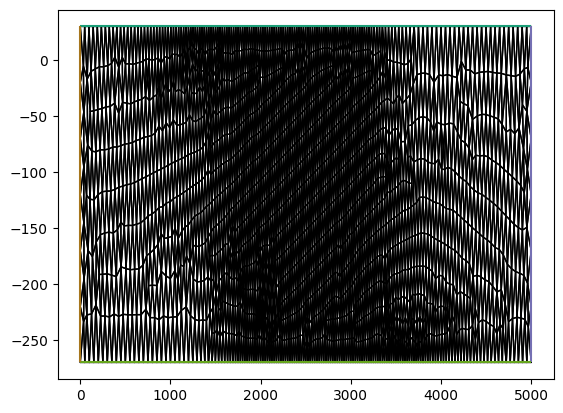

In [3]:
L = 5000

xt = np.linspace(0, L,  201)
yt = 30*np.ones_like(xt)
xb = np.linspace(L, 0, 51)
yb = -270*np.ones_like(xb)

lcs = (50, 25, 25)

generate_mesh(xt,yt,xb,yb,lcs)
mesh = Mesh('channel.msh')
triplot(mesh)

In [4]:
secpera = 31556926.0    # seconds per year
g = 9.81                # m s-2
rho = 900.0             # kg m-3
rhow = 1000.0
n_glen = 3.0
A3 = 3.1689e-24         # Pa-3 s-1;  EISMINT I value of ice softness
B3 = A3**(-1.0/n_glen)     # Pa s(1/3);  ice hardness
Dtyp = 1.0 / secpera    # s-1

    
def D(w):               # strain-rate tensor
    return 0.5 * (grad(w) + grad(w).T)

fbody = Constant((0.0, - rho * g))

In [5]:
def melt(xb):
    return np.exp(-(xb-2500)**2/2500)

Text(0.5, 1.0, 'Prescribed basal melt rates')

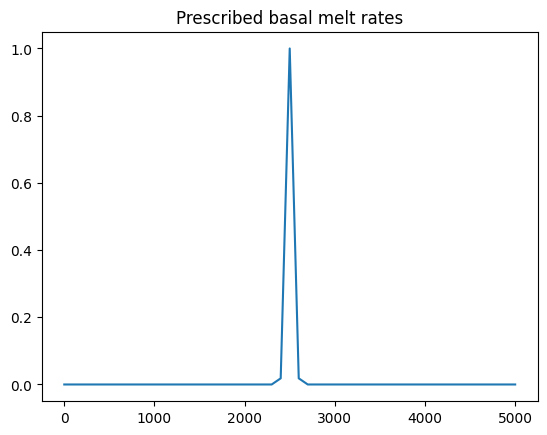

In [6]:
from matplotlib import pyplot as plt
plt.plot(xb,melt(xb))
plt.title('Prescribed basal melt rates')

In [7]:
import copy
t = 0.0

dt = 0.01
t_end = 1

results = []
xsurf = []
ysurf = []
xbase = []
ybase = []

myResults = VTKFile('channel.pvd')
while t<t_end:
    
    generate_mesh(xt,yt,xb,yb,lcs)

    printpar('reading mesh from channel.msh ...')
    mesh = Mesh('channel.msh')
    printpar('    (mesh with %d elements and %d vertices)' \
      % (mesh.num_cells(), mesh.num_vertices()))

    
    printpar = PETSc.Sys.Print        # print once even in parallel
    
    V = VectorFunctionSpace(mesh, 'Lagrange', 2)
    W = FunctionSpace(mesh, 'Lagrange', 1)
    Z = V * W
    
    up = Function(Z)
    u, p = split(up)
    v, q = TestFunctions(Z)
    
    # Get the coordinates of all the nodes in the quadratic space.
    x,y = SpatialCoordinate(mesh)
    
    eps = .01
    
    Du2 = 0.5 * inner(D(u), D(u)) + (eps * Dtyp)**2.0
    nu = 0.5 * B3 * Du2**((1.0 / n_glen - 1.0)/2.0)
 
    def wat_press(y):
        pw = rhow*g*y
        return pw

    #pw = Function(W).interpolate(rhow*g*y)
    pw = Function(W).interpolate(wat_press(y))
    n = FacetNormal(mesh)
    
    F = ( inner(2.0 * nu * D(u), D(v)) \
      - p * div(v) - q * div(u) - inner(fbody, v) ) * dx \
      - pw * inner(n,v) * ds(1073)
      
    bcs = [ DirichletBC(Z.sub(0), Constant((0.0, 0.0)), (1072,1074)) ]
    
    printpar('solving t = ' + str(t) + '....')
    par = {'snes_linesearch_type': 'bt',
       'ksp_type': 'preonly',
       'pc_type': 'lu',
       'pc_factor_shift_type': 'inblocks',
       'snes_max_it': 200}
#       'snes_atol': 1e2}

    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    eps /= 10
    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    
    eps /= 10
    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    
    #eps /= 10
    #solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    #u,p = split(up)
    
    # print average and maximum velocity
    P1 = FunctionSpace(mesh, 'CG', 1)
    one = Function(W).interpolate(1.0)
    area = assemble(dot(one,one) * dx)
    umagav = assemble(sqrt(dot(u, u)) * dx) / area
    umag = assemble(interpolate(sqrt(dot(u, u)), P1))
    with umag.dat.vec_ro as vumag:
        umagmax = vumag.max()[1]
    printpar('  ice speed (m a-1): av = %.3f, max = %.3f' \
         % (umagav * secpera, umagmax * secpera))

    if umagmax*secpera>100:
        dt = 0.001
    elif umagmax*secpera>10:
        dt = 0.0051
    elif umagmax*secpera<1:
        dt = 0.02
    else: 
        dt = 0.01
        
    printpar('saving to channel.pvd ...')
    u = up.subfunctions[0]
    p = up.subfunctions[1]
    P1 = FunctionSpace(mesh, 'CG', 1)
    Du = sqrt(0.5 * inner(D(u), D(u)))
    eff_strain = assemble(interpolate(Du*secpera, P1))
    eff_strain.rename('effective strain rate')
    u *= secpera    # save in m/a
    p /= 1.0e5      # save in bar
    u.rename('velocity (m/a)')
    p.rename('pressure (bar)')
    myResults.write(u, p, eff_strain, time=t)
    result = (t, u.copy(deepcopy=True), p.copy(deepcopy=True), eff_strain.copy(deepcopy=True))
    results.append(result)
    xsurf.append(copy.deepcopy(xt))
    ysurf.append(copy.deepcopy(yt))
    xbase.append(copy.deepcopy(xb))
    ybase.append(copy.deepcopy(yb))
    
    # updating the surface by remeshing
    bound_points = [[xt[i], yt[i]] for i in range(np.size(xt))]
    f = Function(V).interpolate(u)
    u_bound=f.at(bound_points)
    
    ux = np.array([u_bound[i][0] for i in range(len(u_bound))])
    uy = np.array([u_bound[i][1] for i in range(len(u_bound))])
    
    xt += ux*dt
    yt += uy*dt
    
    # updating the bottom by remeshing
    bottom_points = [[xb[i], yb[i]] for i in range(np.size(xb))]
    f = Function(V).interpolate(u)
    u_bottom=f.at(bottom_points)
    
    ux = np.array([u_bottom[i][0] for i in range(len(u_bottom))])
    uy = np.array([u_bottom[i][1] for i in range(len(u_bottom))])

    delx = -np.append(np.append(0,xb[2:]-xb[:-2]),0)
    dely = np.append(np.append(0,yb[2:]-yb[:-2]),0)
    nn = np.sqrt(delx**2+dely**2)
    nn[nn==0] = 1
    nx = -dely/nn
    ny = delx/nn
    m = 10*melt(xb)
    
    xb += ux*dt + m*nx*dt
    yb += uy*dt + m*ny*dt
    
    t += dt

reading mesh from channel.msh ...
    (mesh with 3537 elements and 1929 vertices)
solving t = 0.0....
  ice speed (m a-1): av = 0.000, max = 0.000
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 3580 elements and 1951 vertices)
solving t = 0.02....
  ice speed (m a-1): av = 0.329, max = 0.659
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 3584 elements and 1953 vertices)
solving t = 0.04....
  ice speed (m a-1): av = 3.391, max = 6.375
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 3537 elements and 1929 vertices)
solving t = 0.05....
  ice speed (m a-1): av = 17.751, max = 33.681
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 3586 elements and 1954 vertices)
solving t = 0.0551....
  ice speed (m a-1): av = 42.264, max = 79.610
saving to channel.pvd ...
reading mesh from channel.msh ...
    (mesh with 3537 elements and 1929 vertices)
solving t = 0.060200000000000004....
  ice 

Text(0.5, 1.0, 'Final mesh')

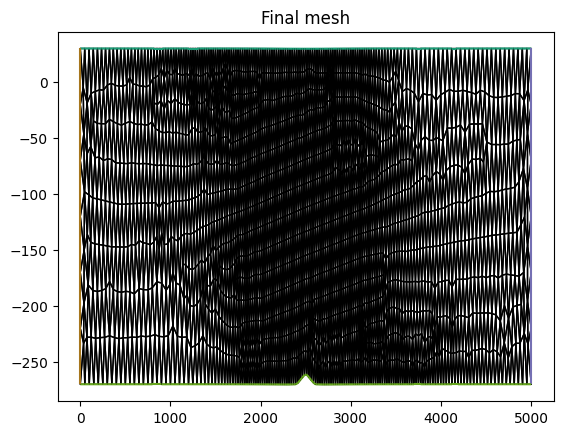

In [8]:
triplot(mesh)
plt.title('Final mesh')

Text(0.5, 1.0, 'Basal profile at final time')

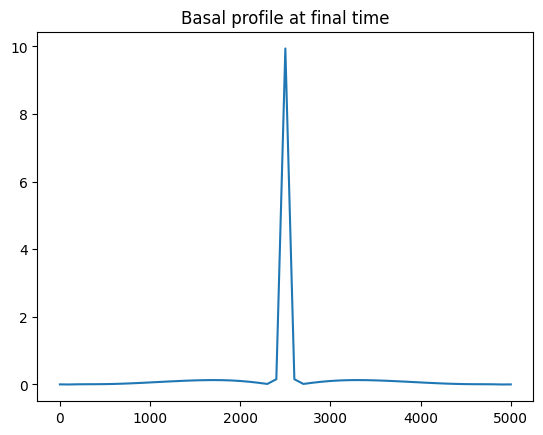

In [9]:
plt.plot(xb,yb+270)
plt.title(f'Basal profile at final time')

Text(0.5, 1.0, 'Surface profile at final time')

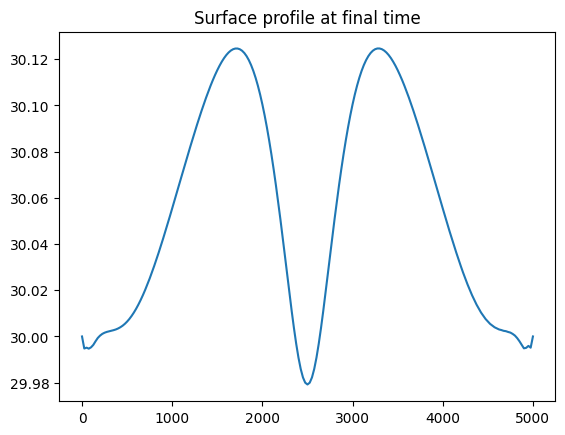

In [10]:
plt.plot(xt,yt)
plt.title(f'Surface profile at final time')

In [11]:
#dx = -np.append(np.append(0,xb[2:]-xb[:-2]),0)
#dy = np.append(np.append(0,yb[2:]-yb[:-2]),0)
#n = np.sqrt(dx**2+dy**2)
#n[n==0] = 1
#nx = -dy/n
#ny = dx/n

In [12]:
#dx

[-270.         -270.00592228 -270.00394751 -270.00773999 -270.01396349
 -270.0198264  -270.02419053 -270.02679906 -270.02784015 -270.02772654
 -270.02690342 -270.02582252 -270.02490531 -270.02457729 -270.02531097
 -270.02766904 -270.03235665 -270.04021647 -270.05220093 -270.06927281
 -270.09219034 -270.1211812  -270.15555952 -270.19391281 -270.05703473
 -260.32339371 -270.05707349 -270.19393844 -270.15558224 -270.12120237
 -270.09220998 -270.06929142 -270.05221956 -270.04023343 -270.03237484
 -270.02768613 -270.02532158 -270.02458736 -270.02491465 -270.02582616
 -270.02690429 -270.02772053 -270.02783423 -270.02678851 -270.0241844
 -270.01982281 -270.0139594  -270.00773186 -270.00392628 -270.00589427
 -270.        ]


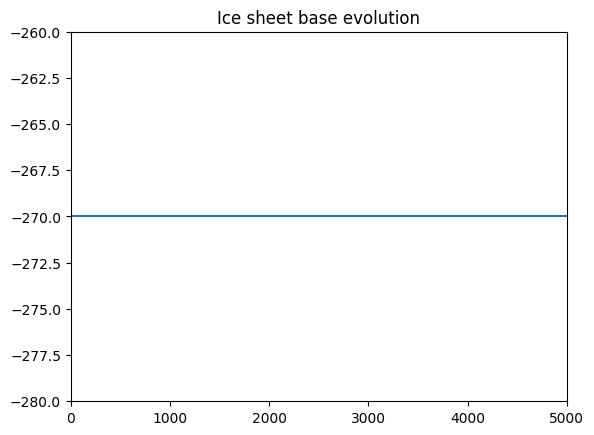

In [13]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

plt.plot(xbase[0], ybase[0])
print(ybase[-1])

def animate(i):
    ax.clear()
    ax.plot(xbase[i], ybase[i])
    ax.set_xlim([0, L])
    ax.set_ylim([-280, -260])
    plt.title('Ice sheet base evolution')
animation = FuncAnimation(fig, animate, frames=len(xbase),
                    interval=500, repeat=False)

from IPython.display import HTML
HTML(animation.to_html5_video())

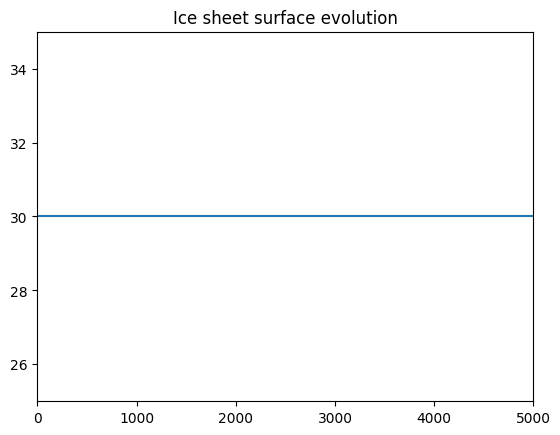

In [14]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

plt.plot(xsurf[0], ysurf[0])

def animate(i):
    ax.clear()
    ax.plot(xsurf[i], ysurf[i])
    ax.set_xlim([0, L])
    ax.set_ylim([25, 35])
    plt.title('Ice sheet surface evolution')
animation = FuncAnimation(fig, animate, frames=len(xsurf),
                    interval=500, repeat=False)

from IPython.display import HTML
HTML(animation.to_html5_video())